In [1]:
%matplotlib inline
import json
import urllib2
import os
from tables import open_file
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from alleninf.api import get_probes_from_genes
from alleninf.data import get_values_at_locations
from alleninf.api import get_mni_coordinates_from_wells#
from alleninf.analysis import fixed_effects, approximate_random_effects, bayesian_random_effects
sns.set_style('white')
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

api_url = "http://api.brain-map.org/api/v2/data/query.json"
ahba_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG5/AHBA2'
ahba_dir  = '/scr/malta3/workspace/project_iron/AHBA'
save_fig_dir        = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'


In [2]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])

    for subject in df.index:
        if df.loc[subject][measure] > upper:
            print subject
        elif df.loc[subject][measure] < lower:
            print subject

In [3]:
df_iron   = pd.read_csv(os.path.join(ahba_dir, 'AHBA_iron_homeostasis.csv'),index_col =0)
df_iron_d = pd.read_csv(os.path.join(ahba_dir, 'AHBA_iron_downreg.csv'),index_col =0)
df_da     = pd.read_csv(os.path.join(ahba_dir, 'AHBA_dopamine.csv'),index_col =0)
df_anmc   = pd.read_csv(os.path.join(ahba_dir, 'AHBA_anmc.csv'),index_col =0)

df_tf  = pd.read_csv(os.path.join(ahba_dir, 'AHBA_bio_tf.csv'),index_col =0)
df_hfe = pd.read_csv(os.path.join(ahba_dir, 'AHBA_bio_hfe.csv'),index_col =0)
df_slc = pd.read_csv(os.path.join(ahba_dir, 'AHBA_bio_slc.csv'),index_col =0)
df_fth = pd.read_csv(os.path.join(ahba_dir, 'AHBA_bio_fth.csv'),index_col =0)
df_all = pd.read_csv(os.path.join(ahba_dir, 'AHBA_bio_all.csv'),index_col =0)

IOError: File /scr/malta3/workspace/project_iron/AHBA/AHBA_iron_homeostasis.csv does not exist

In [ ]:
df  = pd.DataFrame(index = df_iron.index, 
                    columns = ['iron', 'da', 'glu', 'gaba', 'anmc', 
                               'tf', 'hfe', 'slc', 'fth', 'bio',
                               'top_struct', 'struct'])
df['top_struct'] = df_iron.top_struct
df['struct']     = df_iron.struct_name
df['mni']        = list(zip(df_iron.corrected_mni_x,df_iron.corrected_mni_y,df_iron.corrected_mni_z))
df['iron']       = df_iron.PCA
df['iron_d']     = df_iron_d.PCA
df['da']         = df_da.PCA
df['anmc']       = df_anmc.PCA
df['tf']         = df_tf.PCA
df['hfe']        = df_hfe.PCA
df['slc']        = df_slc.PCA
df['fth']        = df_fth.PCA
df['bio']        = df_all.PCA

In [ ]:
mni_coords = get_mni_coordinates_from_wells(df.index)

In [ ]:
def plot_qs_ahba(roi, geneset):

    nifti_img = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG5/AHBA/QSM_MEAN/THR/%s.nii.gz'%roi
    nifti_img = '/scr/malta3/workspace/project_iron/AHBA/RANDOMISE/randomise_SUBCORTICAL_tstat1.nii.gz'
    nifti_values = get_values_at_locations(nifti_file = nifti_img, 
                                           locations= mni_coords, 
                                           radius=2, 
                                           verbose=True)

    g = sns.jointplot(np.array(nifti_values), df[geneset], kind = 'reg', size=7)
    g.fig.suptitle(roi)


In [ ]:
rois = [#'MEAN_lemon_BG', 'MEAN_lemon_BS', 'MEAN_lemon_Caud_Puta','MEAN_lemon_L_BG', 'MEAN_lemon_L_BS',
        #'MEAN_lemon_L_Caud_Puta', 'MEAN_lemon_R_BG', 'MEAN_lemon_R_BS', 'MEAN_lemon_R_Caud_Puta', 
        #'MEAN_lemon_STR3_EXEC', 'MEAN_lemon_STR3_LIMBIC','MEAN_lemon_STR3_MOTOR', 'MEAN_lemon_SUBCORTICAL'
        'MEAN_lemon_Caud_Puta'
        ]

No mask provided - using implicit (not NaN, not zero) mask


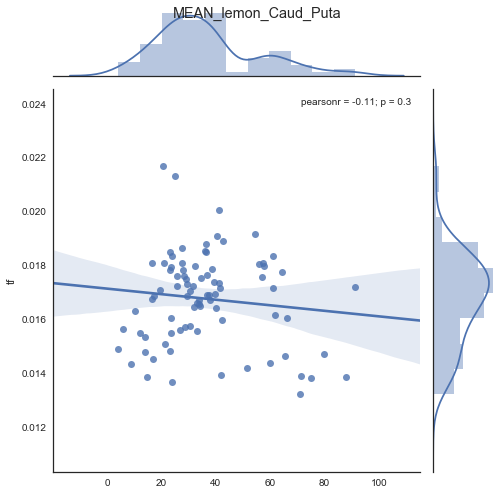

In [8]:
for roi in rois:
    plot_qs_ahba(roi, 'tf')

In [26]:
nifti_img = '/scr/malta3/workspace/project_iron/AHBA/RANDOMISE/randomise_STR3_MOTOR_tstat1.nii.gz'
mean_bg = get_values_at_locations(nifti_file = nifti_img, 
                                       locations= mni_coords, 
                                       radius=2, 
                                       verbose=True)


No mask provided - using implicit (not NaN, not zero) mask


In [126]:
nifti_img = '/scr/malta3/workspace/project_iron/AHBA/RANDOMISE/randomise_SUBCORTICAL_tstat1.nii.gz'
mean_sub = get_values_at_locations(nifti_file = nifti_img, 
                                       locations= mni_coords, 
                                       radius=2, 
                                       verbose=True)


No mask provided - using implicit (not NaN, not zero) mask


In [45]:
threshold = 0.
array = [ x if x >= threshold else np.nan for x in mean_bg ]
len(array)

3702

In [58]:
exc = ['coords_native', 'donor_names', 'struct_id', 'struct_name',
       'top_struct', 'corrected_mni_x',
       'corrected_mni_y', 'corrected_mni_z']


In [155]:
from scipy.stats import pearsonr

cols = [i for i in df_iron.columns if i not in exc]

for i in cols:
    df = pd.DataFrame(columns=  ['X','Y'])
    df['X'] = np.asanyarray(mean_bg)
    df['Y'] = df_iron[i]
    df = df.dropna()
    print i, np.round(pearsonr(df.X, df.Y)[0],2), np.round(pearsonr(df.X, df.Y)[1],4)

FTH1_A_24_P919330 0.04 0.85
FTH1_A_32_P111565 0.08 0.6975
FTH1_A_32_P820503 0.02 0.9213
FTL_A_23_P50498 0.23 0.281
FTL_A_23_P50504 -0.07 0.7536
FTL_A_32_P155247 0.02 0.9309
FTL_A_32_P158433 0.22 0.3008
FTL_CUST_4420_PI416261804 0.07 0.7353
HFE2_A_23_P86315 0.39 0.0574
HFE2_CUST_14045_PI416261804 0.01 0.9458
HFE2_CUST_14048_PI416261804 0.26 0.2267
HFE2_CUST_14051_PI416261804 0.09 0.6889
HFE2_CUST_14052_PI416261804 0.44 0.0331
HFE_A_23_P145204 0.31 0.1471
HFE_A_23_P342009 0.53 0.0075
HFE_A_24_P103448 0.09 0.6692
HFE_A_24_P111996 -0.11 0.6177
HFE_A_24_P289648 0.39 0.0625
HFE_A_24_P354748 0.3 0.1576
IL1A_A_23_P72096 0.18 0.3885
IL1A_CUST_16163_PI416261804 0.49 0.0156
IL6R_A_24_P379413 -0.26 0.2124
IL6R_CUST_14998_PI416261804 -0.32 0.1312
IL6_A_23_P71037 0.37 0.0748
IL6_CUST_15487_PI416261804 0.06 0.7985
IREB2_A_23_P106497 -0.36 0.0871
IREB2_A_24_P188005 -0.03 0.8876
IREB2_A_32_P421898 0.48 0.0166
SLC40A1_A_23_P102391 0.07 0.7437
SLC40A1_A_32_P151454 0.19 0.3694
TFR2_A_23_P122896 0.08 0.693

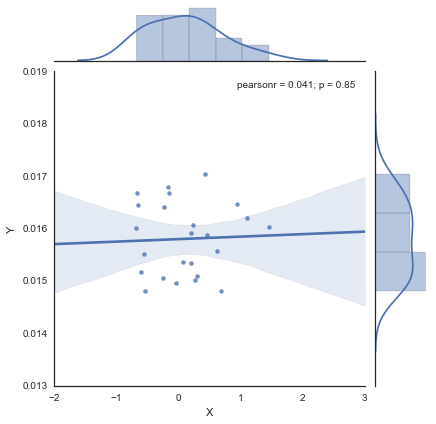

In [160]:
df = pd.DataFrame(columns=  ['X','Y'])
df['X'] = np.asanyarray(mean_bg) * 1e15
df['Y'] = df_all.PCA * 1
df = df.dropna()
sns.jointplot(df.X,df.Y, kind = 'reg')

In [71]:
drop_nii = [13682,
13747,
13769,
139379890,
160091917,
]
drop_nii = [1053,
11270,
11317,
127686973,
127687121,
159226093,
159439025,
2322,
3026
]
drop_nii =[1037,
1053,
11270,
11317,
1138,
1145,
126431643,
127686973,
127687121,
13929,
157772954,
159439121,
2596,
3026,
5018]

drop_nii=[]

df  = pd.DataFrame(index = df_iron.index, 
                    columns = ['iron', 'da', 'glu', 'gaba', 'anmc', 
                               'tf', 'hfe', 'slc', 'fth', 'bio',
                               'top_struct', 'struct'])
m = ['Median']
df['top_struct'] = df_iron.top_struct
df['struct']     = df_iron.struct_name
df['mni']        = list(zip(df_iron.corrected_mni_x,df_iron.corrected_mni_y,df_iron.corrected_mni_z))
df['iron']       = df_iron[m]
df['iron_d']     = df_iron_d[m]
df['da']         = df_da[m]
df['anmc']       = df_anmc[m]
df['tf']         = df_tf[m]
df['hfe']        = df_hfe[m]
df['slc']        = df_slc[m]
df['fth']        = df_fth[m]
df['bio']        = df_all[m]


def plot(df,nii,drop):
    df_nii = pd.DataFrame(index = df.index, columns = ['nifti'])
    df_nii['nifti'] = nii
    dfx = pd.concat([df,df_nii],axis=1)
    
    return dfx.drop(drop,axis=0).reset_index()

dfx = plot(df, mean_bg, drop_nii)


In [72]:
nifti_img

'/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG5/AHBA/QSM_MEAN/MEAN_lemon_BG.nii.gz'

In [73]:
detect_outlier_subjects(df_fth, 'PCA',3)

1037
1053
11270
11317
1138
1145
126431643
127686973
127687121
13929
157772954
159439121
2596
3026
5018


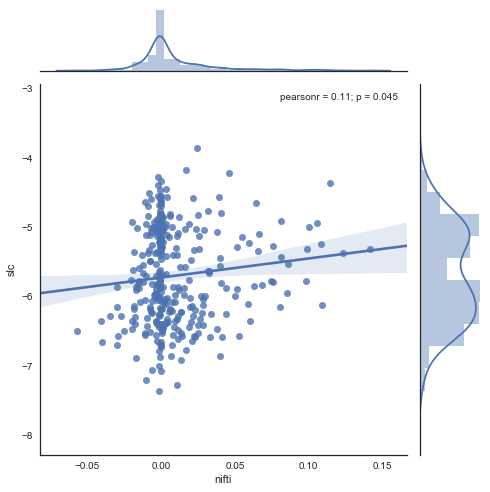

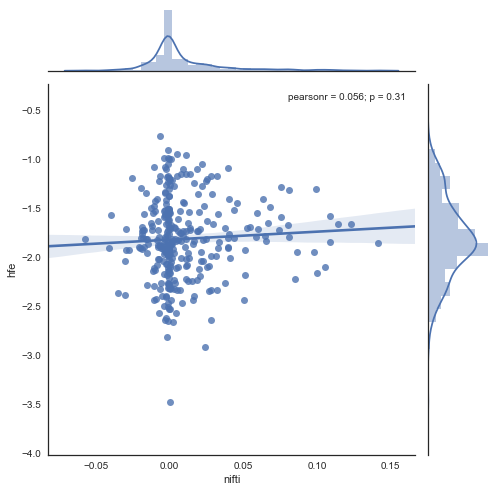

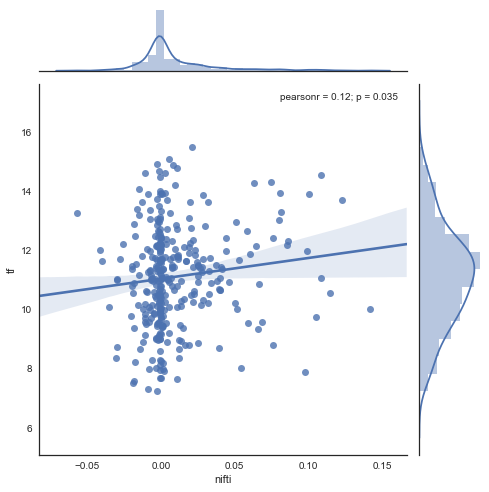

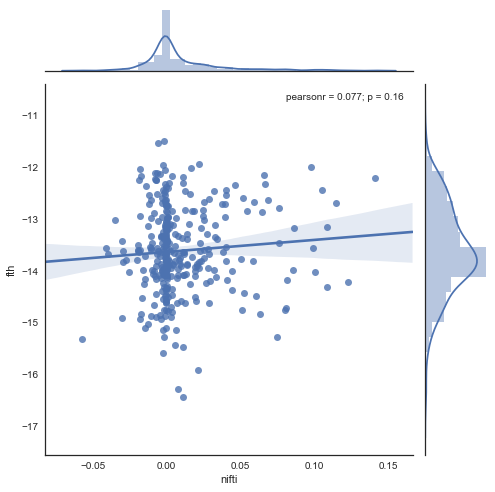

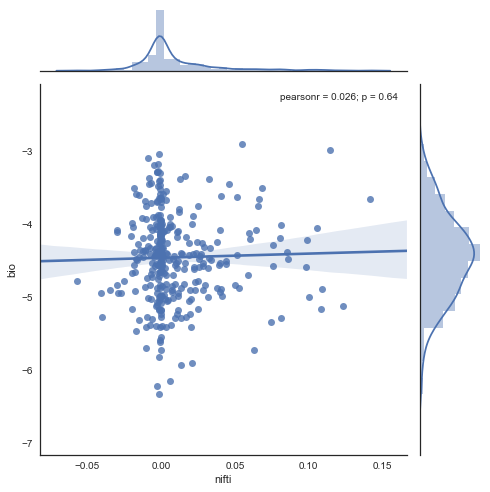

In [74]:
sns.jointplot(dfx.nifti, dfx.slc * -1, kind = 'reg', size=7)
sns.jointplot(dfx.nifti, dfx.hfe * -1, kind = 'reg', size=7)
sns.jointplot(dfx.nifti, dfx.tf , kind = 'reg', size=7)
sns.jointplot(dfx.nifti, dfx.fth * -1 , kind = 'reg', size=7)
sns.jointplot(dfx.nifti, dfx.bio *-1, kind = 'reg', size=7)

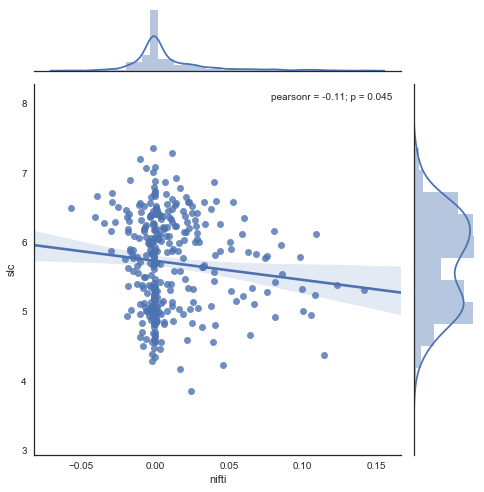

In [77]:
sns.jointplot(dfx.nifti.dropna(), dfx.slc, kind = 'reg', size=7)


In [ ]:
sns.distplot(dfx.nifti.dropna())

In [ ]:
sns.distplot(np.log10(dfx.nifti.dropna()).dropna())

In [52]:
np.log10(dfx.nifti.dropna()).dropna()

/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


175    -1.815089
185    -1.949955
190    -1.468537
227    -1.421374
247    -1.553840
248    -2.106421
250    -1.574392
251    -1.355186
253    -1.290536
257    -2.500265
258    -1.857739
263    -1.546084
266    -2.243165
267    -1.933520
270    -1.567444
271    -2.758240
273    -2.271316
274    -1.664623
277    -1.955254
315    -2.882673
351    -1.599078
362    -1.527587
601    -2.207943
665    -2.101810
670    -1.336604
680    -1.425076
681    -0.849379
682    -1.907000
693    -1.783127
695    -1.394620
698    -1.189855
702    -2.455121
703    -1.176051
707    -1.665637
708    -1.498154
711    -1.182122
712    -1.089931
717    -0.977003
719    -1.962869
723    -0.941081
724    -1.397828
732    -2.436606
781    -2.694981
813    -1.288609
816    -1.165339
819    -1.009271
821    -1.796957
824    -1.908868
831    -1.398045
834    -1.094627
844    -1.859690
851    -3.641134
861    -2.026847
892    -1.988878
897    -3.157988
901    -2.038791
953    -1.722176
965    -1.859718
992    -3.0851